In [1]:
import matplotlib.pyplot as plt
from data201 import db_connection, df_query

%matplotlib inline

In [2]:
conn = db_connection(config_file = 'StudentBookWeights.ini')
cursor = conn.cursor()

In [3]:
cursor.execute('DROP TABLE IF EXISTS weights')

sql = """
    CREATE TABLE weights
    (
        student DOUBLE NOT NULL,
        books   DOUBLE NOT NULL,
        PRIMARY KEY(student, books)
    )
    """

cursor.execute(sql)

## Student and textbook weights

In [4]:
student_weights  = [48.50, 54.50, 61.25, 65.00, 69.00, 74.50, 85.00, 91.23, 89.00, 99.00, 105.00, 112.00, 123.00, 134.00, 142.00]
textbook_weights = [ 8.00,  9.44, 10.08, 11.07, 11.81, 12.28, 13.61, 14.00, 15.13, 15.47,  15.53, 17.36,  18.07,  20.29,  16.06 ]

values = list(zip(student_weights, textbook_weights))

sql = ( """
        INSERT INTO weights
        VALUES (%s, %s)
        """
      )

cursor.executemany(sql, values)
conn.commit()

df = df_query(conn,
        """
        SELECT student AS student_weights,
               books AS book_weights
        FROM weights
        """
)

df

student_weights  book_weights
0             48.50          8.00
1             54.50          9.44
2             61.25         10.08
3             65.00         11.07
4             69.00         11.81
5             74.50         12.28
6             85.00         13.61
7             89.00         15.13
8             91.23         14.00
9             99.00         15.47
10           105.00         15.53
11           112.00         17.36
12           123.00         18.07
13           134.00         20.29
14           142.00         16.06

In [5]:
cursor.close()
conn.close()

## Function to draw a scatter plot with optional line plots

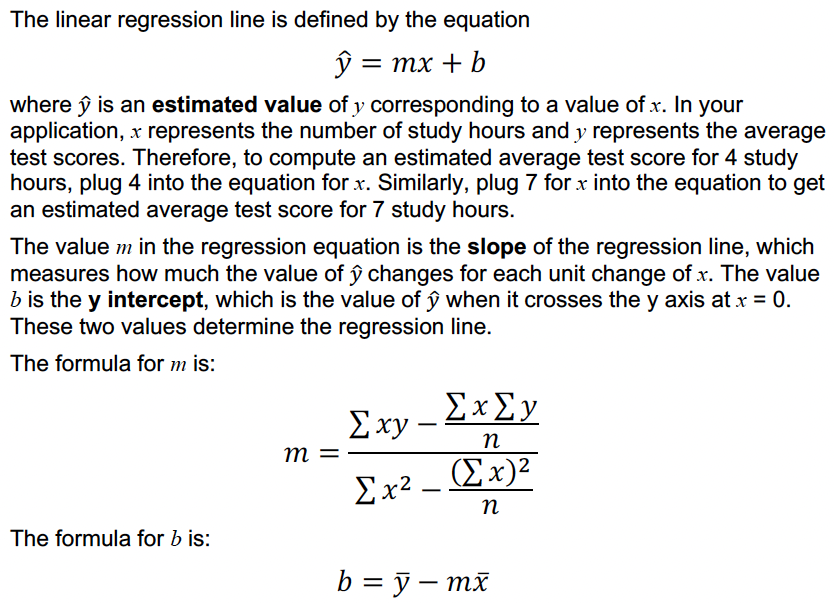
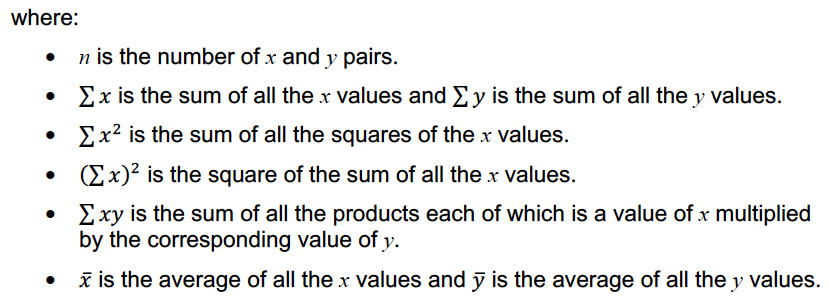

#### The function `plt.plot()` takes a list of the x values and a list of the correspohding y values. Draw the scatter plot if `scatter=True`. If `regression=True`, calculate and draw in red the linear regression trend line with slope `m` and y intercept `b`. We only need the line's end points to plot the line. To make the line cross the y axis, we can make it start at `x = -10` and end it at `x = max(X) + 10`. Then the y values of the end points are `-10*m + b` and `m*(max(X) + 10) + b]`.

In [6]:
def draw_graph(X, Y, m=1, b=0, scatter=True, regression=False):
    """
    Draw a scatter plot of the list of X and Y values if scatter=True.
    If regression=True, also draw the linear regression trend line 
    with slope m and y intercept b.
    """
    x_offset = 10
    y_offset = 2

    min_X = min(X)
    max_X = max(X)
    min_Y = min(Y)
    max_Y = max(Y)

    fig, ax = plt.subplots()

    if scatter:
        plt.scatter(X, Y)
    
    if regression:
        # For the regression line, we only need 
        # the end points (x1,y1) and (x2,y2)
        # End point 1: (min(X), m*min(X) + b)
        # End point 2: (max(X), m*max(X) + b)

        # Adjust the left end of the regression line
        # to make it cross the Y axis.
        x1 = -x_offset
        x2 = max_X + x_offset
        
        # Plot the line.
        y1 = m*x1 + b
        y2 = m*x2 + b
        plt.plot([x1, x2], [y1, y2], color='red')

    # Set the limits of the x-axis and the y-axis.
    ax.set_xlim([-x_offset, max_X + x_offset])
    ax.set_ylim([-y_offset, max_Y + y_offset])
        
    # Set the ticks of the x-axis and the y-axis.
    plt.xticks(range(0, int(max_X + x_offset), x_offset))
    plt.yticks(range(0, int(max_Y + y_offset), y_offset))

    # Position the x-axis and the y-axis to the origin.
    ax.spines.left.set_position('zero')
    ax.spines.bottom.set_position('zero')

    # Remove the top and right spines.
    ax.spines.top.set_color('none')
    ax.spines.right.set_color('none')
    
    # Title and axis labels.
    ax.set_title('Student weights vs. book weights')
    ax.set_xlabel('Student weights')
    ax.set_ylabel('Book weights')

    # Display the graph.
    print()
    plt.show()

## Obtain the current X and Y vectors from the data

In [7]:
weights = df.to_numpy()

X = weights[:, 0]
Y = weights[:, 1]

print(f'{X = }')
print(f'{Y = }')

X = array([ 48.5 ,  54.5 ,  61.25,  65.  ,  69.  ,  74.5 ,  85.  ,  89.  ,
        91.23,  99.  , 105.  , 112.  , 123.  , 134.  , 142.  ])
Y = array([ 8.  ,  9.44, 10.08, 11.07, 11.81, 12.28, 13.61, 15.13, 14.  ,
       15.47, 15.53, 17.36, 18.07, 20.29, 16.06])


## Scatter plot of the data

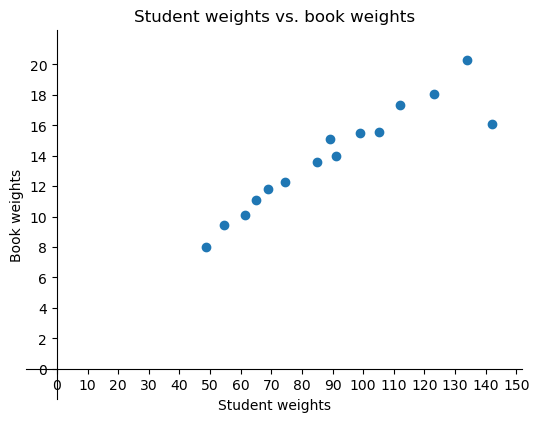

In [8]:
draw_graph(X, Y)

## A Python function to compute the slope and y intercept

In [9]:
def calculate_slope_intercept(X, Y):
    """
    Calculate and return the slope m and y intercept b
    of the least-squares linear regression line y = mx + b
    given the vectors of x and y values.
    """
    n = len(X)
    
    sum_X  = 0
    sum_Y  = 0
    sum_XX = 0
    sum_XY = 0

    for i in range(n):
        x = X[i]
        y = Y[i]
        
        sum_X  += x
        sum_Y  += y
        sum_XX += x*x
        sum_XY += x*y
        
    mean_X = sum_X/n
    mean_Y = sum_Y/n
    
    numerator   = sum_XY - (sum_X*sum_Y)/n
    denominator = sum_XX - ((sum_X*sum_X)/n)
    
    m = numerator/denominator
    b = mean_Y - m*mean_X

    return m, b  # slope and y intercept   

In [10]:
m, b = calculate_slope_intercept(X, Y)

print(f'      slope m = {m:4.2f}')
print(f'y intercept b = {b:4.2f}')

      slope m = 0.11
y intercept b = 3.83


## Scatter plot of the data with line plots

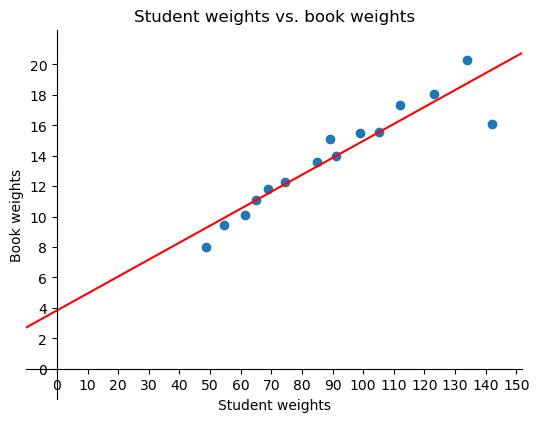

In [11]:
draw_graph(X, Y, m, b, regression=True)

## Calculate the slope and y intercept on the database server
#### If the dataset of X and Y values is large, we don't want to incur the network traffic and latencies by downloading all that data to the client in order to apply a Python function. Instead, we can calculate `m` and `b` in SQL on the database server and then query for those two values along with min(X), max(X), min(Y), and max(Y). Then we can plot the regression line using Python.

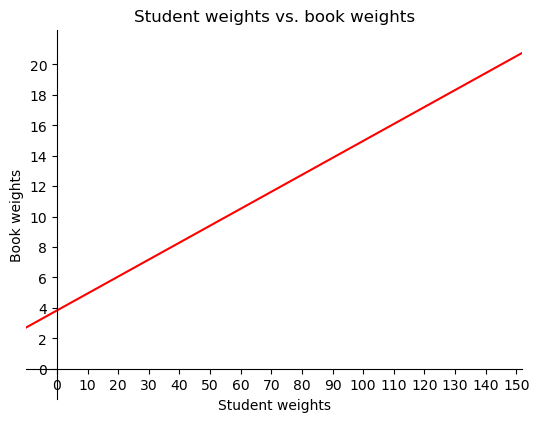

In [12]:
# First query for m, b, min(X) and max(Y) from the database.

# The following four values should be queried from the database.
# Hardcoded here only for this example since we haven't written
# the SQL code.
min_X = min(X)
max_X = max(X)
min_Y = min(Y)
max_Y = max(Y)

# Then we can plot the regression line using the six values
# returned by the query.
draw_graph((min_X, max_X), (min_Y, max_Y), 
           m, b, scatter=False, regression=True)

#### If we want to include a scatter plot, we can download and plot a small random sample of the data.